# 0 导入包

In [1]:
import torch
import cv2 as cv
import os
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import time
from torch.autograd.gradcheck import gradcheck
import matplotlib.pyplot as plt
import io
from scipy import optimize  
from torch.autograd import Variable

# 1  超参数

In [2]:
BATCH_SIZE = 1
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUMWORKERS = 0

# 2 载入数据集

In [3]:
class utcntrain(Dataset):#数据集

    def __init__(self):
    
        '''读训练集图片'''
   
        with open ('data/datasetlist/train_test.txt','r') as tf:
            train_list  = tf.read().splitlines()#这种读取方式和readlines()一样，只是去掉了每一行后面的换行符\n
        
        '''---------------生成一个二维列表，每个小列表里是四张连续图片的地址--------------'''
        trainimage=[]
        i = 0
        while True:
            trainimg=[]
            img1 = train_list[i]
            trainimg.append(img1)
            img2 = train_list[i+1]
            trainimg.append(img2)
            img3 = train_list[i+2]
            trainimg.append(img3)
            img4 = train_list[i+3]
            trainimg.append(img4)
            if i>=len(train_list)-4:
                break
            elif train_list[i+4][:-11] == train_list[i+3][:-11]:#如果在一个文件夹里，继续运行，否则进入下一个文件夹
                i=i+1
            else:
                i=i+4
            trainimage.append(trainimg)
        '''------------------------------------------------------------------------------'''  
        self.train_image=trainimage
        
    def __len__(self):# 返回df的长度
      
        return len(self.train_image)
    
    def __getitem__(self, idx):#idx是索引，根据这个索引返回一个样本
        
 
        train_image_file = self.train_image[idx]
        
        
        image1 = cv.imread('data'+train_image_file[0])
        image2 = cv.imread('data'+train_image_file[1])
        image3 = cv.imread('data'+train_image_file[2])
        image4 = cv.imread('data'+train_image_file[3])
        
        image1 = cv.resize(image1,(328,118))
        image2 = cv.resize(image2,(328,118))
        image3 = cv.resize(image3,(328,118))
        image4 = cv.resize(image4,(328,118))
        
        image1 = np.transpose(image1,(2,0,1))
        image2 = np.transpose(image2,(2,0,1))
        image3 = np.transpose(image3,(2,0,1))
        image4 = np.transpose(image4,(2,0,1))
        
        train_image = np.stack((image1,image2,image3,image4))
        train_image = train_image/255
        
        
        
        labimage = cv.imread('data/label'+train_image_file[3][:-3]+'png',0)#读灰度图
        labimage = cv.resize(labimage,(328,118))
        
        target1 = np.ones_like(labimage)     
        target2 = np.ones_like(labimage)+1
        target3 = np.ones_like(labimage)+2
        target4 = np.ones_like(labimage)+3
        target5 = np.ones_like(labimage)  #background
        target1 = target1==labimage
        target2 = target2==labimage
        target3 = target3==labimage
        target4 = target4==labimage
        target1 = target1.astype(float)
        target2 = target2.astype(float)
        target3 = target3.astype(float)
        target4 = target4.astype(float)
        target5 = target5.astype(float)
        
        labimage = np.stack((target1,target2,target3,target4,target5))
        
#        ret,labimage = cv.threshold(labimage, 0, 1, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)#二值化
        #labimage = np.array([labimage])
        #labimage = np.transpose(labimage, (2,0,1))
        
        return torch.from_numpy(train_image).float(),torch.from_numpy(labimage).float() #读一张图为numpy,返回一个列表里两个tensor。

In [4]:
class utcnval(Dataset):#数据集

    def __init__(self):
    
        '''读训练集图片'''
   
        with open ('data/datasetlist/vallist.txt','r') as tf:
            train_list  = tf.read().splitlines()#这种读取方式和readlines()一样，只是去掉了每一行后面的换行符\n
        
        '''---------------生成一个二维列表，每个小列表里是四张连续图片的地址--------------'''
        trainimage=[]
        i = 0
        while True:
            trainimg=[]
            img1 = train_list[i]
            trainimg.append(img1)
            img2 = train_list[i+1]
            trainimg.append(img2)
            img3 = train_list[i+2]
            trainimg.append(img3)
            img4 = train_list[i+3]
            trainimg.append(img4)
            if i>=len(train_list)-4:
                break
            elif train_list[i+4][:-11] == train_list[i+3][:-11]:#如果在一个文件夹里，继续运行，否则进入下一个文件夹
                i=i+1
            else:
                i=i+4
            trainimage.append(trainimg)
        '''------------------------------------------------------------------------------'''  
        self.train_image=trainimage
        
    def __len__(self):# 返回df的长度
      
        return len(self.train_image)
    
    def __getitem__(self, idx):#idx是索引，根据这个索引返回一个样本
        
 
        train_image_file = self.train_image[idx]
        
        
        image1 = cv.imread('data'+train_image_file[0])
        image2 = cv.imread('data'+train_image_file[1])
        image3 = cv.imread('data'+train_image_file[2])
        image4 = cv.imread('data'+train_image_file[3])
        
        image1 = cv.resize(image1,(328,118))
        image2 = cv.resize(image2,(328,118))
        image3 = cv.resize(image3,(328,118))
        image4 = cv.resize(image4,(328,118))
        
        image1 = np.transpose(image1,(2,0,1))
        image2 = np.transpose(image2,(2,0,1))
        image3 = np.transpose(image3,(2,0,1))
        image4 = np.transpose(image4,(2,0,1))
        
        train_image = np.stack((image1,image2,image3,image4))
        train_image = train_image/255
        
        
        
        labimage = cv.imread('data/label'+train_image_file[3][:-3]+'png',0)#读灰度图
        labimage = cv.resize(labimage,(328,118))
        
        target1 = np.ones_like(labimage)     
        target2 = np.ones_like(labimage)+1
        target3 = np.ones_like(labimage)+2
        target4 = np.ones_like(labimage)+3
        target5 = np.ones_like(labimage)  #background
        target1 = target1==labimage
        target2 = target2==labimage
        target3 = target3==labimage
        target4 = target4==labimage
        target1 = target1.astype(float)
        target2 = target2.astype(float)
        target3 = target3.astype(float)
        target4 = target4.astype(float)
        target5 = target5.astype(float)
        
        labimage = np.stack((target1,target2,target3,target4,target5))
        
#        ret,labimage = cv.threshold(labimage, 0, 1, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)#二值化
        #labimage = np.array([labimage])
        #labimage = np.transpose(labimage, (2,0,1))
        
        return torch.from_numpy(train_image).float(),torch.from_numpy(labimage).float() #读一张图为numpy,返回一个列表里两个tensor。

In [5]:
class utcntest(Dataset):#数据集

    def __init__(self):
    
        '''读训练集图片'''
   
        with open ('data/datasetlist/testlist.txt','r') as tf:
            train_list  = tf.read().splitlines()#这种读取方式和readlines()一样，只是去掉了每一行后面的换行符\n
        
        '''---------------生成一个二维列表，每个小列表里是四张连续图片的地址--------------'''
        trainimage=[]
        i = 0
        while True:
            trainimg=[]
            img1 = train_list[i]
            trainimg.append(img1)
            img2 = train_list[i+1]
            trainimg.append(img2)
            img3 = train_list[i+2]
            trainimg.append(img3)
            img4 = train_list[i+3]
            trainimg.append(img4)
            if i>=len(train_list)-4:
                break
            elif train_list[i+4][:-11] == train_list[i+3][:-11]:#如果在一个文件夹里，继续运行，否则进入下一个文件夹
                i=i+1
            else:
                i=i+4
            trainimage.append(trainimg)
        '''------------------------------------------------------------------------------'''  
        self.train_image=trainimage
        
    def __len__(self):# 返回df的长度
      
        return len(self.train_image)
    
    def __getitem__(self, idx):#idx是索引，根据这个索引返回一个样本
        
 
        train_image_file = self.train_image[idx]
        
        
        image1 = cv.imread('data'+train_image_file[0])
        image2 = cv.imread('data'+train_image_file[1])
        image3 = cv.imread('data'+train_image_file[2])
        image4 = cv.imread('data'+train_image_file[3])
        
        image1 = cv.resize(image1,(328,118))
        image2 = cv.resize(image2,(328,118))
        image3 = cv.resize(image3,(328,118))
        image4 = cv.resize(image4,(328,118))
        
        image1 = np.transpose(image1,(2,0,1))
        image2 = np.transpose(image2,(2,0,1))
        image3 = np.transpose(image3,(2,0,1))
        image4 = np.transpose(image4,(2,0,1))
        
        train_image = np.stack((image1,image2,image3,image4))
        train_image = train_image/255
        
        
        
        labimage = cv.imread('data/label'+train_image_file[3][:-3]+'png',0)#读灰度图
        labimage = cv.resize(labimage,(328,118))
        
        target1 = np.ones_like(labimage)     
        target2 = np.ones_like(labimage)+1
        target3 = np.ones_like(labimage)+2
        target4 = np.ones_like(labimage)+3
        target5 = np.ones_like(labimage)  #background
        target1 = target1==labimage
        target2 = target2==labimage
        target3 = target3==labimage
        target4 = target4==labimage
        target1 = target1.astype(float)
        target2 = target2.astype(float)
        target3 = target3.astype(float)
        target4 = target4.astype(float)
        target5 = target5.astype(float)
        
        labimage = np.stack((target1,target2,target3,target4,target5))
        
#        ret,labimage = cv.threshold(labimage, 0, 1, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)#二值化
        #labimage = np.array([labimage])
        #labimage = np.transpose(labimage, (2,0,1))
        
        return torch.from_numpy(train_image).float(),torch.from_numpy(labimage).float() #读一张图为numpy,返回一个列表里两个tensor。

载入train_loader

In [6]:
traindata = utcntrain()
train_loader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUMWORKERS)
valdata = utcnval()
val_loader = torch.utils.data.DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUMWORKERS)
testdata = utcntest()
test_loader = torch.utils.data.DataLoader(testdata, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUMWORKERS)

------Test code start------

In [7]:
for batch_idx, (data, target) in enumerate(train_loader):
    print('训练集:',data.size(), target.size(),'\n')
    break
for batch_idx, (data, target) in enumerate(val_loader):
    print('验证集:',data.size(), target.size(),'\n')
    break
for batch_idx, (data, target) in enumerate(test_loader):
    print('测试集:',data.size(), target.size(),'\n')
    break

训练集: torch.Size([1, 4, 3, 118, 328]) torch.Size([1, 5, 118, 328]) 

验证集: torch.Size([1, 4, 3, 118, 328]) torch.Size([1, 5, 118, 328]) 

测试集: torch.Size([1, 4, 3, 118, 328]) torch.Size([1, 5, 118, 328]) 



------Test code end------

# 3 Model

## 3.1 TCN部分

### 3.1.1 裁剪多余的Padding

In [7]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size[0]

    def forward(self, x):

        x=x[:, :, :-self.chomp_size].contiguous()

        return x

### 3.1.2 TCN主体（采用3d卷积+残差）

In [8]:
    
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs):

        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv3d(n_inputs, n_outputs, 
                                            kernel_size=(2,3,3), stride=1, padding=(0,1,1), dilation=(1,1,1), bias=True))
        #self.chomp1 = Chomp1d([1,1,1])  
        self.relu1 = nn.ReLU()

        self.conv2 = weight_norm(nn.Conv3d(n_inputs, n_outputs, 
                                            kernel_size=(2,3,3), stride=1, padding=(0,1,1), dilation=(2,1,1), bias=True))
        #self.chomp2 = Chomp1d([2,1,1])  
        self.relu2 = nn.ReLU()
        
        self.net = nn.Sequential(self.conv1, self.relu1,
                                self.conv2,  self.relu2)
        
        
        #self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1,
         #                       self.conv2, self.chomp2, self.relu2)
        
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):

        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        

    def forward(self, x):
        
        out = self.net(x)
       
        res = x 
       
        
        return self.relu(out + res)

## 3.2 UNet部分

In [9]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        return self.conv(x)

## 3.3整合（UNet下采样+TCN+UNet上采样）

In [10]:
class UTCN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UTCN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
 
        self.tcn = TemporalBlock(512,512) #TCN
    
    def forward(self, x):
        xTCN = []
        for i in range(0,4):
            if i==3:
                x1 = self.inc(x[i])
                
                x2 = self.down1(x1)
                
                x3 = self.down2(x2)
                
                x4 = self.down3(x3)
                
                x5 = self.down4(x4)
               
                xTCN.append(x5)
            else:
                xd = self.inc(x[i])
                xd = self.down1(xd)
                xd = self.down2(xd)
                xd = self.down3(xd)
                xd = self.down4(xd)
                xTCN.append(xd)
        xTCN=torch.stack((xTCN[0],xTCN[1],xTCN[2],xTCN[3])) #xTCN.shape()=(D,batch_size,C,H,W)
        
        xTCN=xTCN.permute(1,2,0,3,4)  #输入TCN时，变成（batch_size,C,D,H,W)
        
        xTCN_output = self.tcn(xTCN)
        
        xTCN_output = xTCN_output.permute(2,0,1,3,4) #改回(D,batch_size,C,H,W)
        
        xTCN_output = xTCN_output[3]    #只有最后一个有用
        
        x = self.up1(xTCN_output, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #logits = torch.sigmoid(logits)
        logits = F.softmax(logits,1)
        return logits

In [11]:
class nDoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class nDown(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nDoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
class nfull(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=(7,20), padding=0, stride=1)
        )

    def forward(self, x):
        return self.linear(x)
    
class nliner(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_features=4096, out_features=out_channels)
        )

    def forward(self, x):
        return self.linear(x)
class nUTCN(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(nUTCN, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = nDoubleConv(n_channels, 64)
        self.down1 = nDown(64, 128)
        self.down2 = nDown(128, 256)
        self.down3 = nDown(256, 512)
        self.down4 = nDown(512, 512)
        self.full = nfull(512, 4096)
        self.liner = nliner(4096, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.full(x5)

        x6 = x6.view(x6.size()[0], x6.size()[1])

        x7 = self.liner(x6)

        logits = torch.sigmoid(x7)
        return logits




# 4 损失函数

## 4.1 FocalLoss

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, weight=None, ignore_index=255):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.ignore_index = ignore_index
        self.bce_fn = nn.BCEWithLogitsLoss(weight=self.weight)

    def forward(self, preds, labels):
        if self.ignore_index is not None:
            mask = labels != self.ignore_index
            labels = labels[mask]
            preds = preds[mask]

        logpt = -self.bce_fn(preds, labels)
        pt = torch.exp(logpt)
        loss = -((1 - pt) ** self.gamma) * self.alpha * logpt
        return loss
class MFocalLoss(nn.Module):
    def __init__(self):
        super(MFocalLoss, self).__init__()

    def forward(self, input, target, weights=[2,1,1,2,0]):

        C = target.shape[1]

        # if weights is None:
        # 	weights = torch.ones(C) #uniform weights for all classes

        focal = FocalLoss()
        totalLoss = 0

        for i in range(C):
            focalLoss = focal(input[:,i], target[:,i])
            if weights is not None:
                focalLoss *= weights[i]
            totalLoss += focalLoss
    
        return totalLoss

## 4.3 DiceLoss

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, logits, targets):
        num = targets.size(0)
        smooth = 0
        
        m1 = logits.view(num, -1)
        m2 = targets.view(num, -1)

        intersection = (m1 * m2)
 
        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score


class MulticlassDiceLoss(nn.Module):
    def __init__(self):
        super(MulticlassDiceLoss, self).__init__()

    def forward(self, input, target, weights=None):

        C = target.shape[1]

        # if weights is None:
        # 	weights = torch.ones(C) #uniform weights for all classes

        dice = DiceLoss()
        totalLoss = 0

        for i in range(C):
            diceLoss = dice(input[:,i], target[:,i])
            if weights is not None:
                diceLoss *= weights[i]
            totalLoss += diceLoss
    
        return totalLoss

In [14]:
criterion = MulticlassDiceLoss()

In [17]:
criterion = MFocalLoss()

In [23]:
criterion = FocalLoss()

# 5 训练

## 5.1 初始化

In [15]:
model = UTCN(3,5).to(DEVICE)
model = torch.nn.DataParallel(model)
#optimizer = optim.Adam(model.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [16]:
modeln = nUTCN(3,4).to(DEVICE)
modeln = torch.nn.DataParallel(modeln)

In [21]:
def _initialize_weights(self):
        # print(self.modules())
 
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # print(m.weight.data.type())
                # input()
                # m.weight.data.fill_(1.0)
                init.xavier_uniform_(m.weight, gain=1)
                print(m.weight)
model.apply(_initialize_weights)


DataParallel(
  (module): UTCN(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), p

In [18]:
model.load_state_dict(torch.load('utcn_focal_s_ep1.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

## 5.2 定义训练函数

In [17]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    since = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()        
        data = data.permute(1,0,2,3,4)#(D,B,C,W,H)
        output = model(data)
        lossfn = criterion 
        loss = lossfn(output,target)
        loss.backward()
        
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * BATCH_SIZE, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
        if(batch_idx+1)%1 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * BATCH_SIZE, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            with open('lossdata.txt','a') as f:    #设置文件对象
                f.write('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * BATCH_SIZE, len(train_loader.dataset),
                100. * batch_idx/ len(train_loader), loss.item())+'\n')
                
    time_elapsed = time.time() - since
    print('Train Epoch: {} complete in {:.0f}m {:.0f}s'.format(epoch,
        time_elapsed // 60, time_elapsed % 60))

## 5.3 验证函数

In [18]:
def val(model, device, val_loader, criterion):
    model.eval()
    since = time.time()
    loss_sum=[]
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            
           
            
            data = data.permute(1,0,2,3,4)#(D,B,C,W,H)
            output = model(data)
            lossfn = criterion 
            loss = lossfn(output,target)
            
            loss_sum.append(loss.item())

            if(batch_idx+1)%10== 0: 
                print('Trainval Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * BATCH_SIZE, len(val_loader.dataset),
                    100. * batch_idx / len(val_loader), loss.item()))
                
    time_elapsed = time.time() - since
    print('Train Epoch: {} complete in {:.0f}m {:.0f}s,lossave = {}'.format(epoch,
        time_elapsed // 60, time_elapsed % 60,sum(loss_sum)/len(loss_sum)))

val(model, DEVICE, val_loader, criterion)

## 5.3 训练函数

In [49]:
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch,criterion)
    #val(model, DEVICE, val_loader, criterion)
    
    torch.save(model.state_dict(),'utcn_focal_test1.pt')

Train Epoch: 1 [0/4 (0%)]	Loss: 4.552575
Train Epoch: 1 [0/4 (0%)]	Loss: 4.552575
Train Epoch: 1 [1/4 (25%)]	Loss: 4.622978
Train Epoch: 1 [1/4 (25%)]	Loss: 4.622978
Train Epoch: 1 [2/4 (50%)]	Loss: 4.608305
Train Epoch: 1 [2/4 (50%)]	Loss: 4.608305
Train Epoch: 1 [3/4 (75%)]	Loss: 4.585216
Train Epoch: 1 [3/4 (75%)]	Loss: 4.585216
Train Epoch: 1 complete in 0m 32s
Train Epoch: 2 [0/4 (0%)]	Loss: 4.453030
Train Epoch: 2 [0/4 (0%)]	Loss: 4.453030
Train Epoch: 2 [1/4 (25%)]	Loss: 4.515026
Train Epoch: 2 [1/4 (25%)]	Loss: 4.515026
Train Epoch: 2 [2/4 (50%)]	Loss: 4.478973
Train Epoch: 2 [2/4 (50%)]	Loss: 4.478973
Train Epoch: 2 [3/4 (75%)]	Loss: 4.436114
Train Epoch: 2 [3/4 (75%)]	Loss: 4.436114
Train Epoch: 2 complete in 0m 34s
Train Epoch: 3 [0/4 (0%)]	Loss: 4.286414
Train Epoch: 3 [0/4 (0%)]	Loss: 4.286414
Train Epoch: 3 [1/4 (25%)]	Loss: 4.347209
Train Epoch: 3 [1/4 (25%)]	Loss: 4.347209


KeyboardInterrupt: 

In [50]:
torch.save(model.state_dict(),'utcn_focal_test1.pt')

# 6 测试

In [19]:
def to1(output1,door=0.5):
    if str(output1.dtype)[0:5]!='torch':
        output1 = torch.from_numpy(output1)
    zero = torch.zeros_like(output1)
    ones = torch.ones_like(output1)
    output2 = torch.where(output1 > door, ones,output1)
    output2 = torch.where(output2 <= door, zero,output2)
    output2 = output2.detach().numpy()
    output2=np.array(output2,dtype='int') 
    output2.shape
    return output2

In [20]:
def get_fit_xy(img, right_fit,ylim):
    ploty = np.linspace(ylim, img.shape[0]-1, img.shape[0])
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty**1 + right_fit[2]*ploty**0#+ right_fit[3]
    return right_fitx, ploty

In [22]:
#输入模型输出,输出二次曲线拟合的线
def lines(teoutput01,BATCH_SIZE,lanenum):

    marksmooth1 = np.ones([108,328],dtype = int)
    marksmooth2 = np.ones([10,328],dtype = int)+1
    marksmooth = np.vstack((marksmooth1,marksmooth2))
    marksmooth = np.stack((marksmooth,marksmooth,marksmooth,marksmooth,marksmooth))
    batch_lines = np.zeros([1,4,118,328])
    for numbatch in range(0,BATCH_SIZE):
        lines = np.zeros_like([teoutput01[0][0]])
        teoutput01[numbatch] = (teoutput01[numbatch]==marksmooth)
        
        nonzero_sum = teoutput01[numbatch].nonzero()[1].shape[0]-teoutput01[numbatch][4].nonzero()[1].shape[0]
        for numclass in range(0,4):
            
            nonzero = teoutput01[numbatch][numclass].nonzero()
            
            if lanenum[numbatch][numclass] != 0:
                
                
                
                nonzeroy = np.array(nonzero[0])
                nonzerox = np.array(nonzero [1])
                
                cruve = np.polyfit(nonzeroy,nonzerox, 2)
                #cruvexy = get_fit_xy(teoutput01[0][0],cruve,nonzeroy[0])
                '''
                def func(x,a,b):
                    return a * np.log(x) + b
                popt, pcov = curve_fit(func, x, y)
                a=popt[0]#popt里面是拟合系数，读者可以自己help其用法
                b=popt[1]
                
                popt,pcov=curve_fit(func,nonzerox,nonzeroy)
                yvals=func(x,a,b)
                
                '''
                
                ysum = np.sum(teoutput01[numbatch][numclass][:,:], axis=0)
                for m in range(0,ysum.shape[0]-5):
                    if ysum[m]+ysum[m+1]+ysum[m+2]+ysum[m+3]+ysum[m+4]>10:
                        ylim = m
                    break
                ylim = nonzeroy[0]
                #plt.plot(cruvexy[0],cruvexy[1])
            
                line = np.zeros_like(teoutput01[numbatch][numclass])
                for y in range(0,teoutput01[numbatch][numclass].shape[0]):
                    x = int(cruve[0]*y**2+cruve[1]*y**1+cruve[2])
                    if x<=0 or x>line.shape[1] or y<ylim: 
                        continue
                    for i in range(0,4):
                        for j in range(0,5):
                            if x+j>line.shape[1]-1 or y+i>line.shape[0]-1:
                                break
                            line[y+i][x+j] = 1
            else:
                line = np.zeros_like(teoutput01[numbatch][numclass])
                
            if numclass==0:
                lines = to1(lines + [line], door = 0.9)
            else:
                lines = np.append(lines,[line],axis = 0)
        batch_lines = np.append(batch_lines,[lines],axis = 0)
    return batch_lines

#输入模型输出,输出二次曲线拟合的线
def lines(teoutput01,BATCH_SIZE,lanenum):

    marksmooth1 = np.ones([108,328],dtype = int)
    marksmooth2 = np.ones([10,328],dtype = int)+1
    marksmooth = np.vstack((marksmooth1,marksmooth2))
    marksmooth = np.stack((marksmooth,marksmooth,marksmooth,marksmooth,marksmooth))
    batch_lines = np.zeros([1,4,118,328])
    for numbatch in range(0,BATCH_SIZE):
        lines = np.zeros_like([teoutput01[0][0]])
        teoutput01[numbatch] = (teoutput01[numbatch]==marksmooth)
        
        nonzero_sum = teoutput01[numbatch].nonzero()[1].shape[0]-teoutput01[numbatch][4].nonzero()[1].shape[0]
        for numclass in range(0,4):
            
            nonzero = teoutput01[numbatch][numclass].nonzero()
            if lanenum[numbatch][numclass] != 0:
                
                
                
                nonzeroy = np.array(nonzero[0])
                nonzerox = np.array(nonzero [1])
                
                #cruve = np.polyfit(nonzeroy,nonzerox, 2)
                #cruvexy = get_fit_xy(teoutput01[0][0],cruve,nonzeroy[0])
                
                
                def func(x,a,b,c,d,e,f):
                    return a*x**5+b*x**4+c*x**3+d*x**2+e*x+f
            
                popt,pcov=optimize.curve_fit(func,nonzerox,nonzeroy)
                a=popt[0]#popt里面是拟合系数，读者可以自己help其用法
                b=popt[1]  
                c=popt[2]
                d=popt[3]
                e=popt[4]
                f=popt[5]
                
                ysum = np.sum(teoutput01[numbatch][numclass][:,:], axis=0)
                for m in range(0,ysum.shape[0]-5):
                    if ysum[m]+ysum[m+1]+ysum[m+2]+ysum[m+3]+ysum[m+4]>10:
                        ylim = m
                    break
                ylim = nonzeroy[0]
                #plt.plot(cruvexy[0],cruvexy[1])
                
                line = np.zeros_like(teoutput01[numbatch][numclass])
                for x in range(1,teoutput01[numbatch][numclass].shape[1]):
                    y = func(x,a,b,c,d,e,f)
        
                    if x<=0 or x>line.shape[1] or y<ylim: 
                        continue
                    for i in range(0,4):
                        for j in range(0,5):
                            if x+j>line.shape[1]-1 or y+i>line.shape[0]-1:
                                break
                            line[int(y)+i][int(x)+j] = 1
            else:
                line = np.zeros_like(teoutput01[numbatch][numclass])
                
            if numclass==0:
                lines = to1(lines + [line], door = 0.9)
            else:
                lines = np.append(lines,[line],axis = 0)
        batch_lines = np.append(batch_lines,[lines],axis = 0)
    return batch_lines

In [23]:
def eva(tetarget,liness,value = 0.4):
    TP = 0.0
    TN = 0.0
    FN = 0.0
    FP = 0.0
    
    for numbatch in range(0,BATCH_SIZE):    
        for numclass in range(0,1):
            
            tetarget1 = tetarget.detach().numpy()[:,0:4,:,:]
            intersection = np.logical_and(tetarget1[numbatch][numclass], liness[numbatch][numclass]) 
            union = np.logical_or(tetarget1[numbatch][numclass], liness[numbatch][numclass]) 
            iou_score = np.sum(intersection) / np.sum(union)
            
            if iou_score>= value:
                TP += 1.0
                FP += 0.01

            else:
                TP += 0.01
                FP += 1.0
            if tetarget1[0][0].max != 0 and liness[0][0].max ==0:#漏检
                FN += 1.0
            else:
                FN += 0.01
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    F1 = 2 * r * p / (r + p)
    acc = (TP + TN) / (TP + TN + FP + FN)
    return p,r,F1,acc

In [24]:
i = 0
for tebatch_idx, (tedata, tetarget) in enumerate(test_loader):
    tedata, tetarget = tedata.to(DEVICE), tetarget.to(DEVICE)
    if i == 3:
        break        
    i = i+1

In [25]:
def test(model, device, test_loader, criterion,value):
    p,r,F1,acc = 0.0,0.0,0.0,0.0
    model.eval()
    since = time.time()
    loss_sum=[]
    with torch.no_grad():
        for batch_idx, (tedata, tetarget) in enumerate(test_loader):
            tedata, tetarget = tedata.to(device), tetarget.to(device)
                   
            tedata = tedata.permute(1,0,2,3,4)#(D,B,C,W,H)
            teoutput = model(tedata)
            
            lossfn = criterion 
            loss = lossfn(teoutput,target)
            loss_sum.append(loss.item())
      
            teoutput01 = to1(teoutput,0.99)
            liness = lines(teoutput01,BATCH_SIZE )
            p1,r1,F11,acc1 = eva(tetarget,liness,value)
            p = p+p1
            r = r+r1
            F1 = F1+F11
            acc = acc+acc1
   
            p2 = p/ (batch_idx+1 )* BATCH_SIZE
            r2 = r/ (batch_idx+1 ) * BATCH_SIZE
            F12 = F1/ (batch_idx+1 )* BATCH_SIZE
            acc2 = acc/ (batch_idx+1 ) * BATCH_SIZE
           
         
            break
            if(batch_idx+1)%2== 0: 
                print(p2,r2,F12,acc2)
                print('Trainval Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * BATCH_SIZE, len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), loss.item()))
                
    time_elapsed = time.time() - since
    print('Train Epoch: {} complete in {:.0f}m {:.0f}s,lossave = {}'.format(epoch,
        time_elapsed // 60, time_elapsed % 60,sum(loss_sum)/len(loss_sum)))

# 6 调试

In [70]:
model.load_state_dict(torch.load('utcn_dice_ep3.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [28]:
modeln.load_state_dict(torch.load('one_ep6.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [84]:
numi = 20
imgtest1 = cv.imread('test1/'+str(numi)+'1'+'.jpg')
imgtest2 = cv.imread('test1/'+str(numi)+'2'+'.jpg')
imgtest3 = cv.imread('test1/'+str(numi)+'3'+'.jpg')
imgtest4 = cv.imread('test1/'+str(numi)+'4'+'.jpg')

imgtest1 = cv.resize(imgtest1,(328,118))
imgtest2 = cv.resize(imgtest2,(328,118))
imgtest3 = cv.resize(imgtest3,(328,118))
imgtest4c = cv.resize(imgtest4,(328,118))

imgtest1 = np.transpose(imgtest1, (2,0,1))
imgtest2 = np.transpose(imgtest2, (2,0,1))
imgtest3 = np.transpose(imgtest3, (2,0,1))
imgtest4c = np.transpose(imgtest4c, (2,0,1))

imgtest = np.stack((imgtest1,imgtest2,imgtest3,imgtest4c))
imgtest = imgtest[np.newaxis,:,:,:,:]

imgtest = imgtest.transpose(1,0,2,3,4)
imgtest = imgtest/225
imgtest = torch.from_numpy(imgtest).float()
output = model(imgtest)
output1 = to1(output,door = 0.7)

In [85]:

imgtestn1 = cv.imread('test1/'+str(numi)+'4'+'.jpg')
imgtestn1 = cv.resize(imgtestn1,(328,118))
imgtestn1 = np.transpose(imgtestn1, (2,0,1))
imgtestn1 = imgtestn1[np.newaxis,:,:,:]
imgtestn1 = imgtestn1/225
imgtestn1 = torch.from_numpy(imgtestn1).float()
outputn = modeln(imgtestn1)
outputn1 = to1(outputn,door = 0.9)

print(outputn,outputn1)

tensor([[0.9092, 0.9933, 0.9909, 0.9721]], grad_fn=<SigmoidBackward>) [[1 1 1 1]]


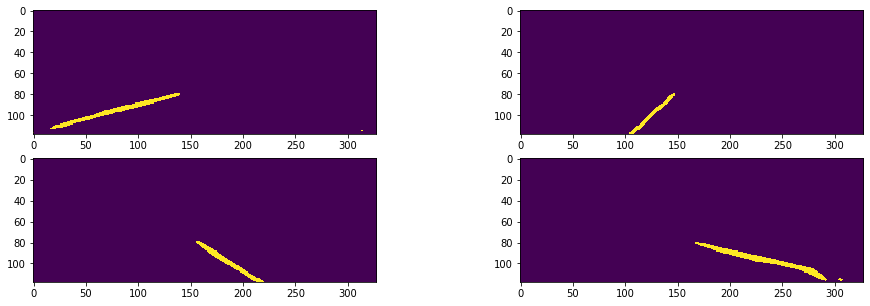

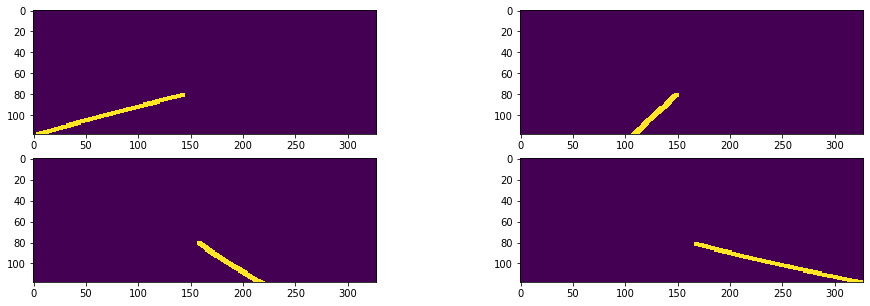

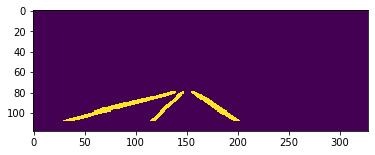

In [86]:
fig = plt.figure(1,figsize=(16, 5))
plt.subplot(221)  
plt.imshow(output1[0][0])
plt.subplot(222) 
plt.imshow(output1[0][1])
plt.subplot(223) 
plt.imshow(output1[0][2])
plt.subplot(224) 
plt.imshow(output1[0][3])
plt.show()

fig = plt.figure(2,figsize=(16, 5))
liness = lines(output1,1,outputn1)
plt.subplot(221)
plt.imshow(liness[1][0])
plt.subplot(222)
plt.imshow(liness[1][1])
plt.subplot(223)
plt.imshow(liness[1][2])
plt.subplot(224)
plt.imshow(liness[1][3])
plt.show()

plt.imshow(output1[0][0]+output1[0][1]+output1[0][2])
plt.show()

(590, 1640, 3)


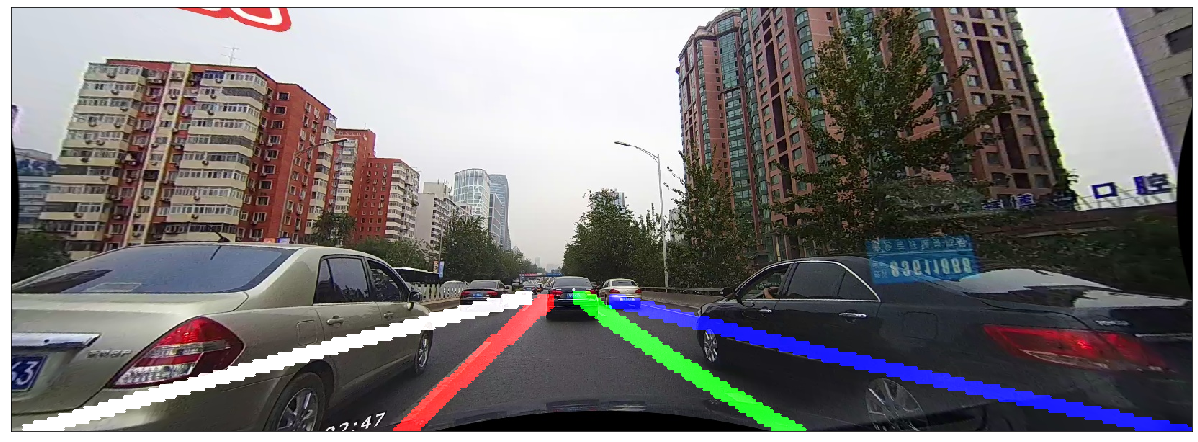

In [83]:
line1 = liness[1][0].astype(np.uint8)
line1 = cv.resize(line1,(1640,590))
line1 = np.stack((line1,line1,line1))
line1 = np.transpose(line1,(1,2,0))

line2 = liness[1][1].astype(np.uint8)
line2 = cv.resize(line2,(1640,590))
line2 = np.stack((np.zeros_like(line2),np.zeros_like(line2),line2))
line2 = np.transpose(line2,(1,2,0))

line3 = liness[1][2].astype(np.uint8)
line3 = cv.resize(line3,(1640,590))
line3 = np.stack((np.zeros_like(line3),line3,np.zeros_like(line3)))
line3 = np.transpose(line3,(1,2,0))

line4 = liness[1][3].astype(np.uint8)
line4 = cv.resize(line4,(1640,590))
line4 = np.stack((line4,np.zeros_like(line4),np.zeros_like(line4)))
line4 = np.transpose(line4,(1,2,0))

img = line1+line2+line3+line4
img =img*225

img = img.astype(np.uint8)
img = cv.resize(img,(1640,590))

imgtest4a = imgtest4.astype(np.float) + img.astype(np.float)
print(imgtest4a.shape)
imgtest4a[imgtest4a > 255] = 255
imgtest4b = imgtest4a.astype(np.uint8)

b,g,r = cv.split(imgtest4b)
imgtest4b = cv.merge([r,g,b])
fig = plt.figure(3,figsize=(16, 7))
plt.imshow(imgtest4b.astype(np.uint8))


fig = plt.gcf()
fig.set_size_inches(16.40,5.90) 

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
fig.savefig('outputimg/'+str(numi)+'2.jpg', format='png', transparent=True, dpi=100, pad_inches = 0)

In [79]:
output1.shape

(1, 5, 118, 328)

In [47]:
nonzero = output1[0][1].nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero [1])

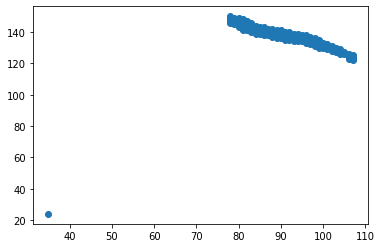

In [54]:
plt.scatter(nonzeroy,nonzerox)
plt.show()

In [68]:
#-*- coding: utf-8 -*-

#使用K-Means算法聚类消费行为特征数据

import numpyas np

import pandasas pd

#参数初始化

inputfile ='路径' #销量及其他属性数据

k =4#聚类的类别

threshold =3 #离散点阈值

iteration =500 #聚类最大循环次数

data = pd.read_excel(inputfile, index_col ='Id')#读取数据

data_zs =1.0*(data - data.mean())/data.std()#数据标准化

from sklearn.clusterimport KMeans

model = KMeans(n_clusters = k, n_jobs =4, max_iter = iteration)#分为k类，并发数4

model.fit(data_zs)#开始聚类

#标准化数据及其类别

r = pd.concat([data_zs, pd.Series(model.labels_, index = data.index)], axis =1)#每个样本对应的类别

r.columns =list(data.columns) + [u'聚类类别']#重命名表头

norm = []

for iin range(k):#逐一处理

    norm_tmp = r[['R', 'F', 'M']][r[u'聚类类别'] == i]-model.cluster_centers_[i]

norm_tmp = norm_tmp.apply(np.linalg.norm, axis =1)#求出绝对距离

  norm.append(norm_tmp/norm_tmp.median())#求相对距离并添加

norm = pd.concat(norm)#合并

import matplotlib.pyplotas plt

plt.rcParams['font.sans-serif'] = ['SimHei']#用来正常显示中文标签

plt.rcParams['axes.unicode_minus'] =False #用来正常显示负号

norm[norm <= threshold].plot(style ='go')#正常点

discrete_points = norm[norm > threshold]#离群点

discrete_points.plot(style ='ro')

for iin range(len(discrete_points)):#离群点做标记

    id = discrete_points.index[i]

n = discrete_points.iloc[i]

plt.annotate('(%s, %0.2f)'%(id, n), xy = (id, n), xytext = (id, n))

plt.xlabel(u'编号')

plt.ylabel(u'相对距离')

plt.show()



[1.0, 1.0]
1.0
1.0
0


IndexError: index 1 is out of bounds for axis 0 with size 0

In [73]:
import numpy as np
import pandas as pd

inputfile = '.../data/consumption_data.xls'
k = 1
threshold = 2
iteration = 500
data = np.stack([nonzerox,nonzeroy])
data_zs = 1.0*(data-data.mean())/data.std()

from sklearn.cluster import KMeans
model = KMeans(n_clusters=k,max_iter=iteration)
model.fit(data_zs)

r = pd.concat([data_zs,pd.Series(model.labels_,index=data.index)],axis=1)
r.columns = list(data.columns) + ['聚类类别']
norm = []
for i in range(k):
    norm_tmp = r[['F','R','M']][r.聚类类别==i] - model.cluster_centers_[i]
    norm_tmp = norm_tmp.apply(np.linalg.norm,axis=1)
    norm.append(norm_tmp/norm_tmp.median()) #计算相对距离（离群点得分）
norm = pd.concat(norm)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
norm[norm <= threshold].plot(style='go')
discrete_points = norm[norm>threshold] # 选出离群点
discrete_points.plot(style='ro')
max_norm_tmp = norm.max()
#离群点标注
for i in range(len(discrete_points)):
    ix = discrete_points.index[i]
    n = discrete_points.iloc[i]
    plt.annotate('%s,%.2f' %(ix,n),xy=(ix,n),xytext=(ix+2,n-max_norm_tmp/50))

plt.xlabel('Id')
plt.ylabel('相对距离')

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [130]:

print(torch.__version__) 

1.4.0
